In [14]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
from utils.config import load_toml, load_json
import seaborn as sns
import pandas as pd

In [15]:
def plot(x, y_mean, y_std=None, x_label="Steps", y_label="Y Label", legend_name="Legend Name",palette="husl"):
    data_preproc = pd.DataFrame({key: value for key, value in y_mean.items()})
    data_preproc[x_label] = x
    color_palette = sns.color_palette(palette, len(y_mean.keys()))
    sns.lineplot(x=x_label, y=y_label, hue=legend_name,palette=color_palette,
                 data=pd.melt(data_preproc, [x_label]).rename(columns={"value": y_label, "variable": legend_name}))
    plt.ylim(0, None)
    plt.xlim(0, None)
    if y_std is not None:
        for key,color in zip(y_mean.keys(),color_palette):
            mean = np.array(y_mean[key])
            std = np.array(y_std[key])/2
            plt.fill_between(data_preproc[x_label], mean + std, mean - std,
                             alpha=0.35,color=color)
    plt.show()

In [16]:
basic_reanalyze_data = load_json("./evaluation_results/final/test_results__group-basic_cartpole.json")
fast_reanalyze_data = load_json("./evaluation_results/final/test_results_fast_reanalyze.json")
true_reanalyze_data = load_json("./evaluation_results/final/test_results_true_reanalyze.json")
configurations = {"basic_cartpole": basic_reanalyze_data,
                  "true_reanalyze_cartpole": true_reanalyze_data,
                  "reanalyze_cartpole": fast_reanalyze_data}
ratios = [0.25, 0.5, 1, 2]
buffer_size = 75
x_label = "Steps"
data = {}
for config_name, config_data in configurations.items():
    data[config_name] = []
    for ratio in ratios:
        string_ratio = str(ratio).replace(".", "_")
        key_name = f"{config_name}_{buffer_size}_ratio_{string_ratio}_sim_50"
        data[config_name].append(np.array(config_data[key_name]))

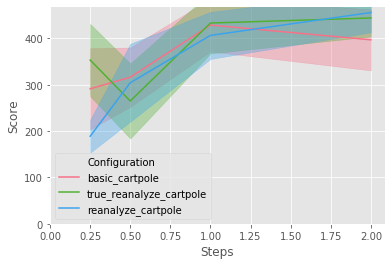

In [18]:
y_mean = {}
y_std = {}
for key, value in data.items():
    y_mean[key] = []
    y_std[key] = []
    for i in range(len(data[key])):
        y_mean[key].append(np.mean(data[key][i]))
        y_std[key].append(np.std(data[key][i]))
with plt.style.context("ggplot"):
    plot(ratios, y_mean, y_std,legend_name="Configuration", y_label="Score")

In [21]:
api = wandb.Api()
evaluation_config_path = "./configs/config.toml"
config = load_toml(evaluation_config_path)
basic_cartpole_ids = ["1f0quoey","1e6j8u4o","153qjoct","18lvaszi","35nozmvj"]
true_reanalyze_ids = ["3cplek04","3ih50gi5","weviku4e","k6xd6war","2oqi8o9f"]
fast_reanalyze_ids = ["11rppoi5","34zu5vue","1eouuvl1","accx95qv","1f5g1b4f"]
basic_cartpole_training_time = [api.run(path=f"{config.wandb.entity}/{config.wandb.project_name}/{id}").summary["_runtime"] for id in basic_cartpole_ids]
true_reanalyze_training_time = [api.run(path=f"{config.wandb.entity}/{config.wandb.project_name}/{id}").summary["_runtime"] for id in true_reanalyze_ids]
fast_reanalyze_training_time = [api.run(path=f"{config.wandb.entity}/{config.wandb.project_name}/{id}").summary["_runtime"] for id in fast_reanalyze_ids]
average_time = {
    "basic_cartpole_score": np.mean(basic_cartpole_training_time) /60,
    "true_reanalyze":np.mean(true_reanalyze_training_time)/60,
    "fast_reanalyze":np.mean(fast_reanalyze_training_time)/60
}
print(average_time)

{'basic_cartpole_score': 11.75375507513682, 'true_reanalyze': 97.9153746318817, 'fast_reanalyze': 15.616902729670207}
